In [1]:
from dotenv import load_dotenv
import os
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [4]:
df_events = client.to_pandas("""

WITH projects AS (
  SELECT
    abp.artifact_id,
    MAX(CASE WHEN pbc.collection_name = '8-3' THEN True ELSE False END) AS is_retrofunded
  FROM artifacts_by_project_v1 AS abp
  LEFT JOIN projects_by_collection_v1 AS pbc ON abp.project_id = pbc.project_id
  WHERE abp.project_source = 'OP_ATLAS'
  GROUP BY 1
)

SELECT
  e.bucket_day,
  CASE
    WHEN p.is_retrofunded = True THEN '1 - Retro Funded'
    WHEN p.is_retrofunded = False THEN '2 - In Atlas'
    ELSE '3 - Other'
  END AS cohort,
  SUM(e.count) AS txn_count
FROM int_events_daily__blockchain AS e
LEFT JOIN projects AS p ON e.to_artifact_id = p.artifact_id
WHERE
  e.bucket_day BETWEEN DATE('2025-04-01') AND DATE('2025-04-30')
  AND e.event_type = 'CONTRACT_INVOCATION'
GROUP BY 1,2
ORDER BY 1

""")

df_events.tail()

,bucket_day,cohort,txn_count
85,2025-04-29,1 - Retro Funded,1418876
86,2025-04-29,3 - Other,10011660
87,2025-04-30,2 - In Atlas,337835
88,2025-04-30,1 - Retro Funded,1154976
89,2025-04-30,3 - Other,11060001


<Axes: xlabel='bucket_day'>

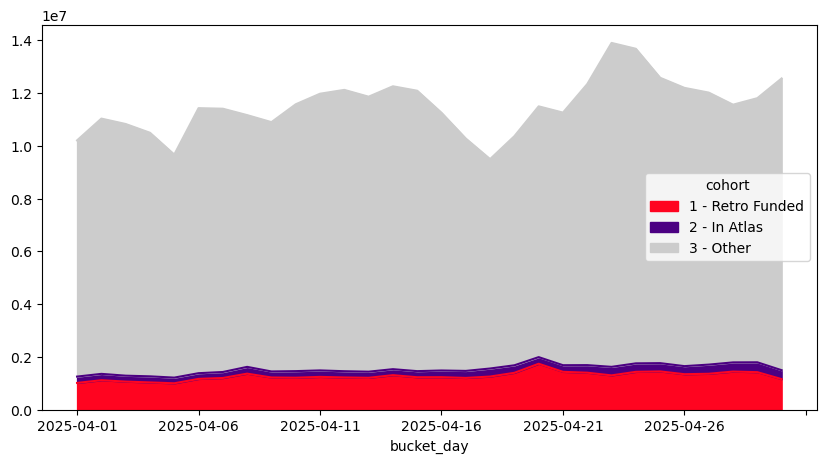

In [3]:
df_events.pivot_table(
    index='bucket_day',
    columns='cohort',
    values='txn_count',
    aggfunc='sum',
    fill_value=0
).plot(
    kind='area',
    figsize=(10,5),
    color=['#ff0420', 'indigo', '#ccc'],        
)